# Event-related desynchronization on motor imagery dataset

Here we shall look at the motor imagery task.  Look at the dataset, this belongs to one participant performing motor imagery task where they were asked to (1) squeeze the ball using their left and right hand (executed condition) and (2) to imagine squeezing the ball using their left and right hand (imagined).

Runs 1 and 2 are fixations, odd runs are 3, 5, 7, 9 are executed, while even runs are 4, 6, 8, 10 are imagined.

In this tutorial, we shall visit (1) event related desynchronization, and (2) convolution for decoding motor imagery.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import create_info
from mne.io import RawArray
from mne import Epochs, find_events
import os

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, WeightedRandomSampler


In [2]:
np.set_printoptions(precision=4)

In [3]:
#this will set the plotting size
mne.set_config('MNE_BROWSE_RAW_SIZE','10,5')  

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

## 0. Config

Below is a one place for all configurable parameters

In [6]:
base_url = '../data/S020'
runs = ['04', '06', '08']

in_channels  = 2  #C3, C4
out_channels = 5  #five is logical because we have freq= 8, 9, 10, 11, 12 that we want to capture
out_size     = 2  #left or right
kernel_size  = 250 #1 second

BATCH_SIZE   = 9999 #basically use whole batch size...
lr           = 1e-6
weight_decay = 1e-1

num_epochs = 1000

modelpath  = '../models/motorCNN1D.pth.tar'

## 1. Loading the data

In [7]:
raws = []

for run in runs:
    filename = f'S020R{run}_raw'
    path_file = os.path.join(base_url, filename + '.fif')
    raw = mne.io.read_raw_fif(path_file , preload=True, verbose='Warning')
    raws.append(raw)

eeg = mne.io.concatenate_raws(raws)
df = eeg.to_data_frame()
print(df.shape)
df.head()


(164135, 10)


,time,Fp1,Fp2,C3,C4,P7,P8,O1,O2,STIM MARKERS
0,0.000,4540.332127,9255.253710,8237.534203,4396.565724,9441.242553,10069.550015,15487.277880,8926.370181,0.0
1,0.004,4542.366136,9257.377125,8261.405863,4408.680368,9452.306665,10094.583966,15499.794856,8948.833682,0.0
2,0.008,4533.716012,9246.648289,8278.572001,4407.518078,9457.984008,10106.430389,15505.427495,8962.021209,0.0
3,0.012,4525.803495,9238.489904,8261.987008,4389.949609,9444.796480,10086.291470,15496.285632,8946.442045,0.0
4,0.016,4527.412821,9239.629842,8239.031769,4382.618237,9435.006417,10066.621937,15489.893034,8927.487768,0.0


Since motor imagery mostly lies on C3 and C4, let's drop all other columns

In [8]:
df = df[['C3', 'C4', 'STIM MARKERS']]
df.head()

,C3,C4,STIM MARKERS
0,8237.534203,4396.565724,0.0
1,8261.405863,4408.680368,0.0
2,8278.572001,4407.518078,0.0
3,8261.987008,4389.949609,0.0
4,8239.031769,4382.618237,0.0


We shall also drop from the raw file, so the meta data of raw will be updated.

In [9]:
eeg = eeg.drop_channels(['Fp1', 'Fp2', 'P7', 'P8', 'O1', 'O2'])
eeg.ch_names

['C3', 'C4', 'STIM MARKERS']

One run (file) contains 15 of left, 15 of right, where label 1 stands for left, 2 for right, and 4 for fixation.  We have total of three files, thus a total of 60 trials.   (I did not use run 10 because when I EDA, it does not look good).

In [10]:
np.unique(df['STIM MARKERS'], return_counts=True)

(array([0., 1., 2., 4.]), array([163865,     45,     45,    180]))

## 2. Artifact Removal

In [11]:
eeg.notch_filter(50)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


<Raw | S020R04_raw.fif, 3 x 164135 (656.5 s), ~3.8 MB, data loaded>

In [12]:
#motor imagery falls in this range
eeg.filter(7, 14)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


<Raw | S020R04_raw.fif, 3 x 164135 (656.5 s), ~3.8 MB, data loaded>

Effective window size : 1.024 (s)


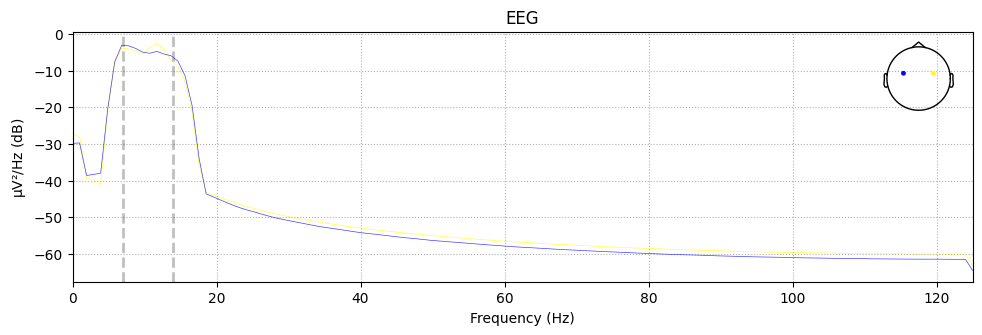

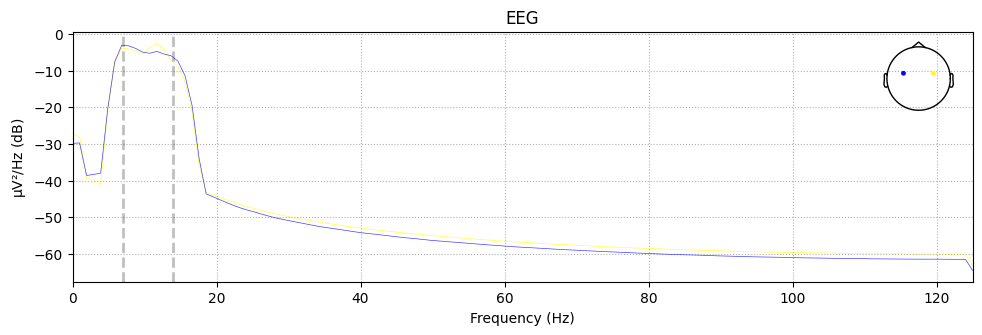

In [13]:
eeg.compute_psd().plot()

## 3. Epoching

To understand how we gonna epoch this, let's look at our experiment setup.

<img src = "figures/exp.png" width = 400>

Each trial is 7s long, where the real imagined happens at 2 to 5s.

In [14]:
def getEpochs(raw, events, event_id, tmin, tmax, picks, baseline):

    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, 
                    baseline=baseline, preload=True,picks=picks)  #2 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [15]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'Left': 1, 'Right' : 2}
events = find_events(eeg)
events_no_fixation = mne.pick_events(events, exclude=4) #ignore fixation
tmin=0
tmax=7
baseline=(0, 2) #baseline is from 0 to 2s which is 2s before the real event starts.  We subtract to enlarge our signal
eeg_channels = mne.pick_types(eeg.info, eeg=True)
picks= eeg_channels
epochs = getEpochs(eeg, events, event_id, tmin, tmax, picks=picks, baseline=baseline)

270 events found
Event IDs: [1 2 4]
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 1751 original time points ...
3 bad epochs dropped
sample drop %:  67.77777777777779


In [16]:
epochs #all the fixation is dropped while 4 bad epochs on the right side also got dropped...

Number of events,87
Events,Left: 45Right: 42
Time range,0.000 – 7.000 sec
Baseline,0.000 – 2.000 sec


## 4. EDA - Event Related Desynchronization

First, we shall use event-related desynchronization.  Event-related desynchronization/synchronization (ERD/ERS) is a relative power decrease/increase of electroencephalogram (EEG) in a specific frequency band during physical motor execution and mental motor imagery.

So first, we shall extract the power in different frequency band.  

Note that we cannot use `compute_psd` since it will just ignore the time element.  We shall instead use window-based psd using the multitaper technique.

In [17]:
from mne.time_frequency import tfr_multitaper

freqs = np.arange(7, 14)  # range of motor imagery

tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=1)

Not setting metadata


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished


For plotting, we need to make baseline correction, and make it into percent, so it can plot around the zero line.

In [18]:
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

Applying baseline correction (mode: percent)


<EpochsTFR | time : [0.000000, 7.000000], freq : [7.000000, 13.000000], epochs : 87, channels : 2, ~16.3 MB>

Let's convert to dataframe to understand what is happening.

In [19]:
df = tfr.to_data_frame(time_format=None, long_format=True)

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


So this basically list the power of each freq across all epochs.

In [20]:
df.head()

,condition,epoch,freq,time,channel,ch_type,value
0,Left,1,7.0,0.000,C3,eeg,-0.702342
1,Left,1,7.0,0.000,C4,eeg,-0.398629
2,Left,1,7.0,0.004,C3,eeg,-0.701238
3,Left,1,7.0,0.004,C4,eeg,-0.381013
4,Left,1,7.0,0.008,C3,eeg,-0.699695


Let's look at the unique frequencies we have, and how many of them.  As you can see, we have equal amounts of each frequencies, since we analyze each epoch across all frequencies.

In [21]:
np.unique(df.freq, return_counts=True)

(array([ 7.,  8.,  9., 10., 11., 12., 13.]),
 array([304674, 304674, 304674, 304674, 304674, 304674, 304674]))

Let's assign whether is theta, beta, etc. based on the freq bounds

In [22]:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}

df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                labels=list(freq_bounds)[1:])

print(df.shape)
print(np.unique(df.band, return_counts=True))

df.head()

(2132718, 8)
(array(['alpha', 'theta'], dtype=object), array([1828044,  304674]))


,condition,epoch,freq,time,channel,ch_type,value,band
0,Left,1,7.0,0.000,C3,eeg,-0.702342,theta
1,Left,1,7.0,0.000,C4,eeg,-0.398629,theta
2,Left,1,7.0,0.004,C3,eeg,-0.701238,theta
3,Left,1,7.0,0.004,C4,eeg,-0.381013,theta
4,Left,1,7.0,0.008,C3,eeg,-0.699695,theta


In [23]:
#it seems only 3-7 belongs to theta, thus only 7 is here, since we
#cut from 7 to 14
df[df.band=='theta'].freq.unique()

array([7.])

In [24]:
#8 ranges from 8 til 13
df[df.band=='alpha'].freq.unique() 

array([ 8.,  9., 10., 11., 12., 13.])

Let's clean some categories that have no rows, in case later we need to use `len()`

In [25]:
df['band'] = df['band'].cat.remove_unused_categories() 
df['band'].cat.categories

Index(['theta', 'alpha'], dtype='object')

Finally, let's plot

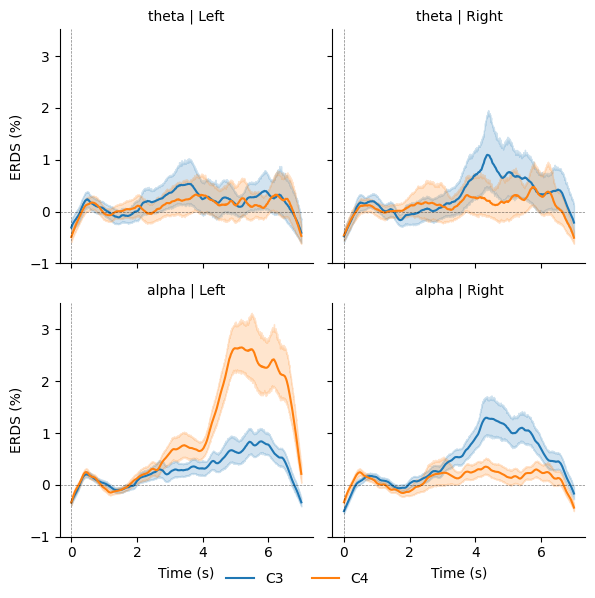

In [26]:
import seaborn as sns

#gives us a easy band x left/right plots
g = sns.FacetGrid(df, row='band', col='condition')

#plot the lineplot on each grid using these df columns
#basically snslineplot(x, y, hue)
g.map(sns.lineplot, 'time', 'value', 'channel')

#trivial styles
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)  #just for easy spot
g.map(plt.axvline, x=0, **axline_kw)  #just for easy spot
g.set(ylim=(-1, None))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig

As you can see, whether the imagined movements was left or right can be seen clearly between the interaction of C3 and C4.  This is a common phenemonon reported in all literatures.

## 5. Machine Learning

Before we tried end-to-end neural network without feature engineering, we can try machine learning.  Machine learning with the right features are usually very competitive!

You can skip this part because it takes a long time.

In [27]:
df.head(1)

,condition,epoch,freq,time,channel,ch_type,value,band
0,Left,1,7.0,0.0,C3,eeg,-0.702342,theta


In [28]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df['channel'] = labelencoder.fit_transform(df['channel'])
df.head()

,condition,epoch,freq,time,channel,ch_type,value,band
0,Left,1,7.0,0.000,0,eeg,-0.702342,theta
1,Left,1,7.0,0.000,1,eeg,-0.398629,theta
2,Left,1,7.0,0.004,0,eeg,-0.701238,theta
3,Left,1,7.0,0.004,1,eeg,-0.381013,theta
4,Left,1,7.0,0.008,0,eeg,-0.699695,theta


In [29]:
X = df[['value', 'freq', 'channel', 'time']]
y = df['condition']

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1492902, 4), (639816, 4), (1492902,), (639816,))

### 5.1 Simple fitting

To save time, let's just run super simple fitting to check accuracy

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier()
score = clf.fit(X_train, y_train)

y_hat = clf.predict(X_test)
print("Test acc: ", accuracy_score(y_test, y_hat))

Test acc:  0.7057466521624968


### 5.2 Feature Importance

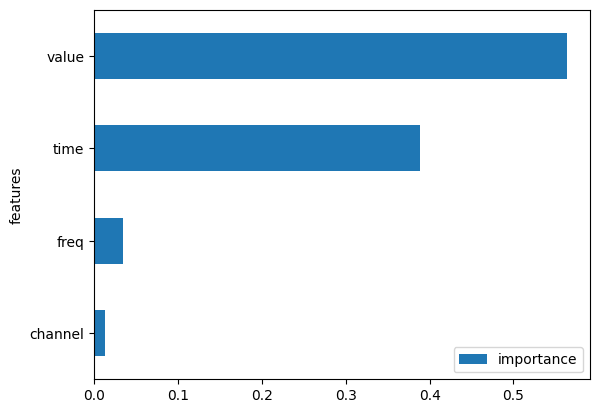

In [69]:
clf.feature_importances_ 
feature_importance = pd.DataFrame(['value', 'freq', 'channel', 'time'], 
                                  columns=['features'])

feature_importance['importance'] = clf.feature_importances_ 
feature_importance = feature_importance.sort_values(by = ['importance'], ascending=True)

feature_importance.plot.barh(x='features')
plt.show();

It's very clear the power is the one that determines left or right

### 5.3 Cross-validation

If you want, you can try cross-validation, but it will take long time

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

cls = RandomForestClassifier()
score = cross_val_score(cls, X_train, y_train)

print("CV acc: ", score.mean())

CV acc:  0.7020427321388698


### 5.4 Grid search

You can also try grid-search, but will take very long time.  I have skipped for sanity.

In [34]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'max_depth'   : [5, 10, None],
#     'n_estimators': [5, 6, 7, 8]
# }

# #3. define the base model
# rf = RandomForestClassifier()

# #4. create the gridsearch object
# grid = GridSearchCV(estimator=rf,param_grid=param_grid,
#                     n_jobs=-1,return_train_score=True,refit=True)

# #5. run grid search
# grid.fit(X_train, y_train)

# #6. inference
# y_hat = grid.predict(X_test)
# print("Test acc: ", accuracy_score(y_test, y_hat))

## 6. Feature Extraction

Now that we try the machine learning.  Let's try create an end-to-end model without any feature engineering, i.e., no extraction of frequency.  We let the neural network figure it out by itself.

Let's get our X and y in numpy form. Here X should have shape of `(batch, channels, length)` and y should have shape of `(batch)`.

For calculate of samples, since we get 0 to 7 seconds, and our sampling rate is 250, thus the total sample is 7 * 250 = 1750.  We got 1751, probably just signal jittering.

In [35]:
X = epochs.get_data()
y = epochs.events[:, -1]

print(X.shape)
# print(y.shape)
print(type(X))

(87, 2, 1751)
<class 'numpy.ndarray'>


In [36]:
X[0].shape

(2, 1751)

In [37]:
X[0][:2]

array([[ 1.3539e-06,  1.6512e-06,  1.8493e-06, ..., -2.3419e-07,
         1.6556e-07,  5.3335e-07],
       [ 7.6302e-07,  8.0512e-07,  8.4050e-07, ...,  2.2971e-06,
         1.5442e-06,  7.7565e-07]])

In [38]:
y[0]

1

**Important**: It's sometimes very important to shuffle your dataset, to avoid any possible order effects of your experiment.   As for MI experiment, I thought it was very important thus I shuffle it to be sure.

In [39]:
from sklearn.utils import shuffle

In [40]:
X = shuffle(X, random_state=42)
X.shape

(87, 2, 1751)

In [41]:
X[0][:2]

array([[ 2.7170e-06,  2.8551e-06,  2.8384e-06, ..., -1.8331e-06,
        -1.0298e-06, -1.7742e-07],
       [ 1.5892e-06,  1.8722e-06,  2.0080e-06, ...,  3.6022e-07,
         1.8155e-07,  5.6890e-08]])

Splitting

In [42]:
train_size  = int(X.shape[0] * 0.7)
val_size    = int(X.shape[0] * 0.2)
test_size   = X.shape[0] - train_size - val_size

#use our numpy indexing technique
X_train   = X[:train_size]
X_val     = X[train_size:val_size+train_size]
X_test    = X[-test_size:]

y_train   = y[:train_size]
y_val     = y[train_size:val_size+train_size]
y_test    = y[-test_size:]

In [43]:
X_train.shape, X_val.shape, X_test.shape

((60, 2, 1751), (17, 2, 1751), (10, 2, 1751))

**Important**:  We need to do some scaling, since EEG values are either very small or very big.  If not, the training won't go well due to vanishing/exploding gradients.  Minmax normalization is a common tool for applying on signals.

In [44]:
from sklearn.preprocessing import MinMaxScaler

#scale transform each channel independently
scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler(feature_range=(0, 1))
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_val.shape[1]):
    X_val[:, i, :]   = scalers[i].transform(X_val[:, i, :])     
    
for i in range(X_test.shape[1]):
    X_test[:, i, :]  = scalers[i].transform(X_test[:, i, :]) 

In [45]:
print(X_train.mean(), X_val.mean(), X_test.mean())
print(X_train.min(), X_val.min(), X_test.min())
print(X_train.max(), X_val.max(), X_test.max())

0.5000046139248385 0.49981424958261594 0.4992292592749264
0.0 -0.6349846630827395 -0.7835945438820104
1.0000000000000002 1.693128309680588 1.6338817754402974


Convert to torch tensor for pyTorch

In [46]:
X_train = torch.FloatTensor(X_train)
X_val   = torch.FloatTensor(X_val)
X_test  = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train) - 1 #minus 1 so it becomes 0 or 1
y_val   = torch.LongTensor(y_val)   - 1 #minus 1 so it becomes 0 or 1
y_test  = torch.LongTensor(y_test)  - 1 #minus 1 so it becomes 0 or 1

Let's check the distribution of the class, to see whether there is class imbalance

In [47]:
print(len(y_train[y_train == 0]), len(y_train[y_train == 1]))
print(len(y_val[y_val == 0]),     len(y_val[y_val == 1]))
print(len(y_test[y_test == 0]),   len(y_test[y_test == 1]))

31 29
9 8
5 5


**Important**: Let's utilize the `Dataset` and `WeightRandomSampler` since our class is not exactly balanced.  What we can do is to force every batch to have the same amount of each class.

The idea is to assign bigger weight to minority class, thus penaltizing if it is wrong.

In [48]:
labels_unique, counts = np.unique(y, return_counts=True)
labels_unique, counts

(array([1, 2]), array([45, 42]))

In [49]:
class_weights = [sum(counts) / c for c in counts]
class_weights

[1.9333333333333333, 2.0714285714285716]

Now we are ready to create the `WeightRandomSampler`

In [50]:
sample_weights_train = [class_weights[i] for i in y_train]
sample_weights_val   = [class_weights[i] for i in y_val  ]
sample_weights_test  = [class_weights[i] for i in y_test ]

sample_weights_train[:10]

[1.9333333333333333,
 2.0714285714285716,
 1.9333333333333333,
 2.0714285714285716,
 1.9333333333333333,
 2.0714285714285716,
 1.9333333333333333,
 2.0714285714285716,
 1.9333333333333333,
 2.0714285714285716]

In [51]:
train_sampler = WeightedRandomSampler(sample_weights_train, len(y_train), replacement=True)
val_sampler   = WeightedRandomSampler(sample_weights_val,   len(y_val),   replacement=True)
test_sampler  = WeightedRandomSampler(sample_weights_test,  len(y_test),  replacement=True)

In [52]:
# Define dataset
ds_train = TensorDataset(X_train, y_train)
ds_val   = TensorDataset(X_val, y_val)
ds_test  = TensorDataset(X_test, y_test)

In [53]:
#Train set loader
train_loader = torch.utils.data.DataLoader(dataset=ds_train, 
                                           batch_size=BATCH_SIZE, 
                                           sampler = train_sampler)
#Validation set loader
val_loader   = torch.utils.data.DataLoader(dataset=ds_val, 
                                           batch_size=BATCH_SIZE, 
                                           sampler = val_sampler)

#Test set loader
test_loader  = torch.utils.data.DataLoader(dataset=ds_test, 
                                          batch_size=BATCH_SIZE, 
                                          sampler = test_sampler)

## 6.1 Testing how train loader works

In [54]:
torch.set_printoptions(sci_mode=False)
for X_train, y_train in train_loader:
    print(torch.mean(X_train, axis=[1,2])) #mean across all channels and sequences
    print(y_train)
    break

tensor([0.5027, 0.5004, 0.4981, 0.5007, 0.4986, 0.5010, 0.5004, 0.4978, 0.4987,
        0.5018, 0.4988, 0.4983, 0.5005, 0.5010, 0.4988, 0.4986, 0.4985, 0.5007,
        0.4991, 0.5006, 0.5006, 0.4981, 0.4985, 0.4978, 0.4998, 0.5030, 0.4963,
        0.4985, 0.5019, 0.5027, 0.5010, 0.4992, 0.5004, 0.4989, 0.5003, 0.4985,
        0.4992, 0.4982, 0.4998, 0.4989, 0.5005, 0.5006, 0.4990, 0.5010, 0.4997,
        0.5018, 0.5011, 0.5007, 0.5006, 0.5022, 0.5002, 0.4989, 0.5018, 0.4981,
        0.4995, 0.5007, 0.4982, 0.4989, 0.4998, 0.4988])
tensor([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0])


## 7. Models

## 7.1 Let's see how each layer works

In [55]:
fake_eeg_data = torch.randn_like(X_train) #(batch_size, channel, length)

In [56]:
conv1d = nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
        nn.ReLU(inplace=True),
        nn.MaxPool1d(10, stride=2),
        nn.BatchNorm1d(out_channels),
        nn.Dropout(0.50)
)

In [57]:
out = conv1d(fake_eeg_data)
out.shape

torch.Size([60, 5, 747])

In [58]:
out = out.reshape(out.size(0), -1)
linear_shape = out.shape[1]
linear_shape

3735

In [59]:
fc = nn.Linear(linear_shape, out_size)
out = fc(out)
out.shape

torch.Size([60, 2])

### 7.2 Defining the model

The model can be much complex, but let me just try one conv1d.  I did not use LSTM since LSTM is not so good for very long sequence.

In [60]:
class motorCNN1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, out_size):
        super().__init__()
        
        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.ELU(inplace=True),
            nn.AvgPool1d(10, stride=2),
            nn.BatchNorm1d(out_channels),
            nn.Dropout(0.50)
        )
                
        self.fc = nn.Linear(linear_shape, out_size)
        
    def forward(self, seq):
        out = self.conv1d(seq)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
        

In [61]:
model = motorCNN1D(in_channels, out_channels, kernel_size, out_size).to(device)

## 8. Training

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = lr)

In [63]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [64]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model) #why 400?, why 10000????

  2500
     5
     5
     5
  7470
     2
______
  9987


In [65]:
best_valid_loss = float('inf')
model.train()

#print(f"Training {type(model).__name__}")

for i in range(num_epochs):
    train_total = 0
    train_correct = 0
    val_total   = 0  
    val_correct = 0
    train_acc   = 0
    val_acc     = 0
    
    for X_train, y_train in train_loader:
    
        start_time = time.time()
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        yhat_train = model(X_train)
                
        #train acc
        _, predicted = torch.max(yhat_train.data, 1)  #returns max value, indices
        
        train_total += y_train.size(0)  #keep track of total
        train_correct += (predicted == y_train).sum().item()  #.item() give the raw number
        train_acc = 100 * (train_correct / train_total)
        
        train_loss = criterion(yhat_train, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        end_time = time.time()

        #val accuracy
        for X_val, y_val in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            yhat_val  = model(X_val)
            val_loss     = criterion(yhat_val, y_val)
            _, predicted = torch.max(yhat_val.data, 1)  #returns max value, indices
            val_total += y_val.size(0)  #keep track of total
            val_correct += (predicted == y_val).sum().item()  #.item() give the raw number
            val_acc = 100 * (val_correct / val_total)

        #save the best model
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            #print("Model:{} saved.".format(type(model).__name__))
            torch.save(model.state_dict(), modelpath)
            best_model_index = i

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if i%100 == 0:
        print(f"Epoch: {i:4.0f} | Train acc: {train_acc: 3.2f} | " +
          f"loss: {train_loss:3.2f} | Val acc: {val_acc: 3.2f} | " +
          f"loss: {val_loss:3.2f} | Time: {epoch_mins}m {epoch_secs}s")

Epoch:    0 | Train acc:  45.00 | loss: 0.80 | Val acc:  41.18 | loss: 1.24 | Time: 0m 1s
Epoch:  100 | Train acc:  63.33 | loss: 0.73 | Val acc:  41.18 | loss: 0.93 | Time: 0m 0s
Epoch:  200 | Train acc:  61.67 | loss: 0.68 | Val acc:  35.29 | loss: 0.84 | Time: 0m 0s
Epoch:  300 | Train acc:  50.00 | loss: 0.83 | Val acc:  64.71 | loss: 0.71 | Time: 0m 0s
Epoch:  400 | Train acc:  60.00 | loss: 0.68 | Val acc:  58.82 | loss: 0.74 | Time: 0m 0s
Epoch:  500 | Train acc:  56.67 | loss: 0.72 | Val acc:  58.82 | loss: 0.82 | Time: 0m 0s
Epoch:  600 | Train acc:  56.67 | loss: 0.67 | Val acc:  70.59 | loss: 0.66 | Time: 0m 0s
Epoch:  700 | Train acc:  63.33 | loss: 0.63 | Val acc:  41.18 | loss: 0.87 | Time: 0m 0s
Epoch:  800 | Train acc:  70.00 | loss: 0.57 | Val acc:  29.41 | loss: 1.08 | Time: 0m 0s
Epoch:  900 | Train acc:  65.00 | loss: 0.56 | Val acc:  64.71 | loss: 0.70 | Time: 0m 0s


## 9. Inference / Testing

In [66]:
model = motorCNN1D(in_channels, out_channels, kernel_size, out_size).to(device)
model.load_state_dict(torch.load(modelpath))

model.eval()

with torch.no_grad():
    total   = 0
    correct = 0
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        predictions   = model(X_test)
        test_loss     = criterion(predictions, y_test)
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()  #.item() give the raw number
        acc = 100 * (correct / total)
    
print(f"Accuracy: {acc:2.3f}")

Accuracy: 70.000


Not really impressive accuracy.  The accuracy fluctuates a lot...  Here if we can design a good neural network, it should perform on-par with machine learning.   Lessons learned:

1. Always EDA, if not, you won't know what you are modeling
2. Try machine learning + feature engineering, to know that it can be predicted